In [453]:
import pandas as pd 
import numpy as np
import pylab as plt 
import os
import shutil
import json 

from collections import defaultdict

In [471]:
# "distortion": 1.0024048812562527,
# "frechet": 18.86473915385344,
# "directionality": 13.544692737430168,
# "monotonicity": 5.726256983240224,
# "projected_monotonicity": 0.0037938796748620504,
# "SL_angle": 0.5253465401656082,
# "mean_edge_length_difference": 2.2065501609141793,
# "inkratio": 0.9363746908612415,
# "mean_occupation_area": 28.519553072625698,
# "edge_density_distribution": 0.1843612641096115

#"ambiguity_1", "precision_1", "specificity_1", "FPR_1"
metrics = ["distortion", "frechet", "directionality", "monotonicity", "projected_monotonicity", "mean_edge_length_difference", 
           "inkratio", "mean_occupation_area", "edge_density_distribution", 
            'self_intersections', 'directionality_mag', 
            'ambiguity_1', 'precision_1', "specificity_1", "FPR_1"]
# metrics = sum(([f'ambiguity_{i}', f"precision_{i}", f"specificity_{i}", f"FPR_{i}"] for i in range(1,5)),start=metrics)
# metrics += ["order", "size", "density", "apl", "cc", "diameter", "connectivity", "algebraic"]

In [ ]:
outdir = "dashboard/output_dashboard"

graphmap = dict()
algmap   = dict() 

results = {metric: defaultdict(dict) for metric in metrics}
for graphname in os.listdir(outdir):
    if ".csv" in graphname: continue
    if not all(os.path.isfile(f"{outdir}/{graphname}/{alg}.json") for alg in ['cubu', 'epb', 'fd', 'sepb', 'wr']): 
        shutil.rmtree(f"{outdir}/{graphname}")
        continue
    for alg in ['cubu', 'epb', 'fd', 'sepb', 'wr']:

        try: 
            with open(f"{outdir}/{graphname}/{alg}.json") as fdata:
                jsdata = json.load(fdata)
        except: 
            continue


        for metric in metrics:
            results[metric][graphname][alg] = jsdata['graph'][metric] if metric in jsdata['graph'] else -100
        # if results["distortion"][graphname][alg] < 50: print(graphname, alg)
        # if np.isnan(results["distortion"][graphname][alg]): print(graphname, alg)

        # if np.isnan(results["edge_density_distribution"][graphname][alg]): print(graphname, alg)
        # if results['frechet'][graphname][alg] < -50: 
        #     shutil.rmtree(f"{outdir}/{graphname}")
        #     print(graphname, alg)

        # import csv
        # jsdata['graph']['instance'] = graphname
        # file_exists = os.path.isfile('dashboard/output_dashboard/instances.csv')
        # with open('dashboard/output_dashboard/instances.csv', 'a') as f:    
        #     writer = csv.DictWriter(f, delimiter=';', lineterminator='\n',fieldnames=jsdata['graph'])

        #     if not file_exists:
        #         writer.writeheader()
            
        #     writer.writerow(jsdata['graph'])            



In [473]:
mdf = {metric: pd.DataFrame(res) for metric,res in results.items()}

In [474]:
mdf['inkratio'].to_csv("out.csv")

In [475]:
arrdata = list()

for i, graph in enumerate(results['distortion'].keys()):
    graphmap[i] = graph
    for j, alg in enumerate(results['distortion'][graph].keys()):
        algmap[j] = alg
        arrdata.append([i,j])

        for metric in metrics:
            arrdata[-1].append(results[metric][graph][alg])

arr = np.array(arrdata)

In [476]:
from scipy.stats import spearmanr
correlations = np.zeros((len(metrics), len(metrics)))
for i in range(2,2+len(metrics)): 
    for j in range(2,i):

        x1 = arr[:,i]
        x2 = arr[:,j]

        fig, ax = plt.subplots()
        ax.scatter(x1,x2,c=arr[:,1])
        ax.set_title(f"{metrics[i-2]} - {metrics[j-2]}")

        fig.savefig(f"figures/scatterplots/{i}-{j}.png")
        plt.close(fig)

        ranks = spearmanr(x1,x2)
        correlations[i-2][j-2] = ranks.statistic
        correlations[j-2][i-2] = ranks.statistic

/tmp/ipykernel_83276/2342836156.py:16: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  ranks = spearmanr(x1,x2)


In [477]:
for i in range(len(metrics)):
    print(i+2, metrics[i],np.max(arr[:,i+2]))

2 distortion 1.1511645606283605
3 frechet 113.94480439007869
4 directionality 0.5141684736894525
5 monotonicity 0.3043709452385488
6 projected_monotonicity 0.027572193509784706
7 mean_edge_length_difference 251.66106997695516
8 inkratio 1.0402259217735281
9 mean_occupation_area 78.66666666666667
10 edge_density_distribution 0.1596657931804657
11 self_intersections 0.689423017633649
12 directionality_mag 13.372717533764988
13 ambiguity_1 0.9918981481481483
14 precision_1 1.0
15 specificity_1 1.0
16 FPR_1 0.0


In [488]:
arr[:,3].mean()

np.float64(38.249062487982975)

In [478]:
for i in range(len(metrics)):
    print(i+2, metrics[i],np.min(arr[:,i+2]))

2 distortion 1.0004789729913075
3 frechet 1.2100778810209876
4 directionality 0.0
5 monotonicity 0.0
6 projected_monotonicity 0.0
7 mean_edge_length_difference 0.22883254439265302
8 inkratio 0.3305604704183942
9 mean_occupation_area 3.6568047337278107
10 edge_density_distribution 0.01541905291378498
11 self_intersections 0.0
12 directionality_mag 0.019270670154820316
13 ambiguity_1 0.07847884831410062
14 precision_1 1.0
15 specificity_1 0.0625
16 FPR_1 0.0


In [479]:
from sklearn.preprocessing import RobustScaler, MinMaxScaler

inp = RobustScaler().fit_transform(arr[:,2:17])
# inp = arr[:,2:]


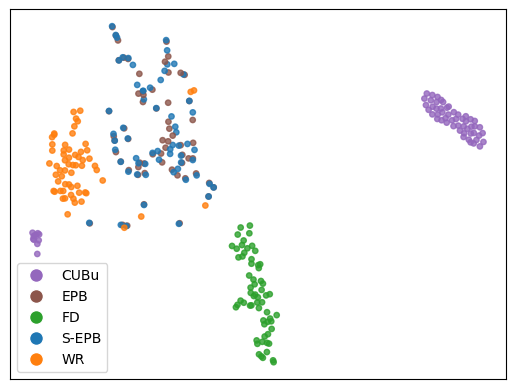

In [480]:
from sklearn.manifold import TSNE
from umap import UMAP

# X = UMAP(n_neighbors=25).fit_transform(inp)
X = TSNE(perplexity=30).fit_transform(inp)

colors = ["#9467bd", "#8c564b", "#2ca02c", "#1f77b4", "#ff7f0e", ]
c = [colors[int(i)] for i in arr[:,1]]

plt.scatter(X[:,0], X[:,1], c=c,s=15,alpha=0.8)
# Create legend handles

handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=colors[i], markersize=10) for i in range(5)]
labmap = {
    "cubu": "CUBu", "epb": "EPB", "fd": "FD", "sepb": "S-EPB", 'wr': "WR"
}
labels = [labmap[algmap[i]] for i in range(5)]

# Add the legend
plt.legend(handles=handles, labels=labels,)

plt.xticks([])
plt.yticks([])

# plt.suptitle("t-SNE plot of bundle algorithms")
plt.savefig("figures/tsne.pdf")

In [481]:
X.shape[0] // 5

62

In [482]:
overviewdata = list()
for i,row in enumerate(arr):
    gid = row[0]
    algid = row[1]
    metricvals = row[2:]
    overviewdata.append({
            'id': i, 
            'graph': graphmap[gid],
            'alg': algmap[algid],
        } | {metric: float(mval) for metric,mval in zip(metrics,metricvals)}
        | {'tsnex': float(X[i,0]), 'tsney': float(X[i,1])}
    )

In [483]:
import json 
with open("dashboard/overview.json", 'w') as fdata:
    json.dump(overviewdata,fdata,indent=4)

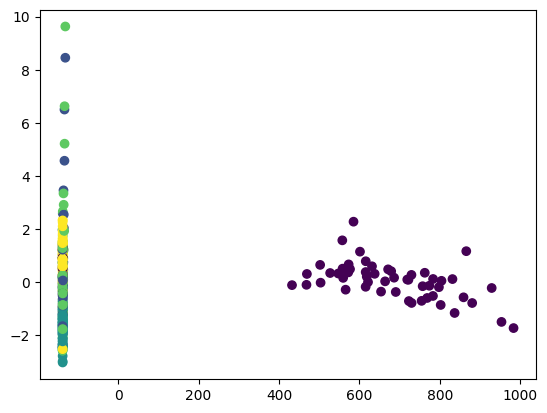

In [484]:
from sklearn.decomposition import PCA
X = PCA(2).fit_transform(inp)

plt.scatter(X[:,0], X[:,1], c=arr[:,1])

In [485]:
metricmap = {metric: i for i,metric in enumerate(metrics)}

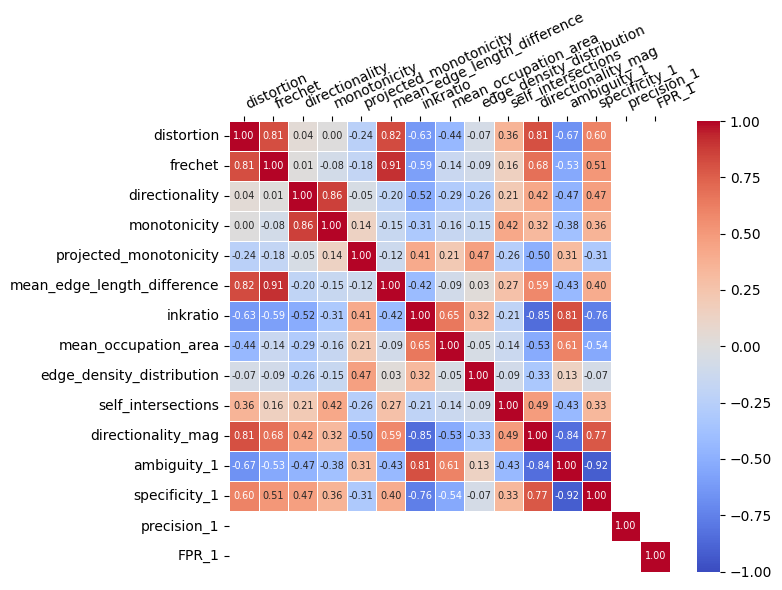

In [486]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

corr_metrics = ["distortion", "frechet", "directionality", "monotonicity", "projected_monotonicity", "mean_edge_length_difference", 
           "inkratio", "mean_occupation_area", "edge_density_distribution", 
            'self_intersections', "directionality_mag",
            "ambiguity_1", "specificity_1", "precision_1", "FPR_1"]

# corr_metrics += ["order", "size", "density", "apl", "cc", "diameter", "connectivity", "algebraic"]

n = len(corr_metrics)
correlation_matrix = np.zeros((n, n))
for i,m1 in enumerate(corr_metrics):
    for j,m2 in enumerate(corr_metrics):
        if i == j: continue
        correlation_matrix[i,j] = correlations[metricmap[m1]][metricmap[m2]]
        # correlation_matrix[j,i] = correlations[metricmap[m1]][metricmap[m2]]

np.fill_diagonal(correlation_matrix,1.0)
# mask = np.triu(np.ones_like(correlation_matrix, dtype=bool),k=1)

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', xticklabels=corr_metrics, yticklabels=corr_metrics, fmt=".2f", linewidths=0.5,
            vmin=-1,vmax=1,annot_kws={"size": 7})


# plt.yticks(rotation=45,ha='right')
plt.gca().xaxis.set_ticks_position('top')
plt.xticks(rotation=25,ha='left')

# plt.title('Correlation Heatmap of Objects')
plt.tight_layout()
plt.savefig("figures/correlations.pdf")

In [487]:
import scipy.cluster.hierarchy as sch
linkage = sch.linkage(correlation_matrix, method='single', metric='euclidean')
dendro = sch.dendrogram(linkage, no_plot=True)
order = dendro['leaves']

reorder = correlation_matrix[order,:][:,order]

ValueError: The condensed distance matrix must contain only finite values.

In [ ]:
order

[13, 7, 6, 11, 2, 3, 12, 1, 5, 0, 10, 9, 14, 4, 8]

In [ ]:
namemaps = {
    "mean_occupation_area": "MOA",
    "ambiguity_1": "Ambiguity",
    "inkratio": "Ink Ratio",
    "specificity_1": "Specificity",
    "precision_1": "Precision",
    "distortion": "Distortion",
    "FPR_1": "False Positive Rate",
    "frechet": "Fréchet",
    "mean_edge_length_difference": "Mean Edge Length Diff.",
    "monotonicity": "Monotonicity",
    "self_intersections": "Self-Intersections",
    "projected_monotonicity": "Projected Monotonicity",
    "edge_density_distribution": "Edge Density Distribution",
    "directionality": "Directionality Change",
    "directionality_mag": "Path Quality",
    "density": "Density", 
    "order": "|V|",
    "size": "|E|",
    "apl": "APL",
    "cc": "Clust. Coef.",
    "diameter": "Diameter",
    "connectivity": "Node Conn.",
    "algebraic": "Algebraic Conn."

}

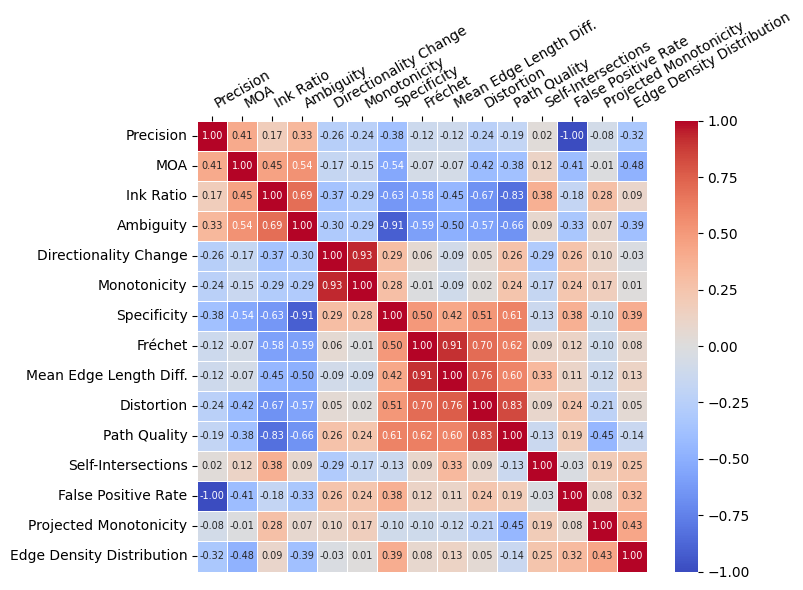

In [ ]:
# Plot heatmap
labels = [corr_metrics[n] for n in order]
labels = [namemaps[l] for l in labels]
plt.figure(figsize=(8, 6))
sns.heatmap(reorder, 
            annot=True, 
            cmap='coolwarm', 
            xticklabels=labels, 
            yticklabels=labels, 
            fmt=".2f", 
            linewidths=0.5,
            vmin=-1,vmax=1,
            annot_kws={"size": 7}
    )


# plt.yticks(rotation=45,ha='right')
plt.gca().xaxis.set_ticks_position('top')
plt.xticks(rotation=30,ha='left')

# plt.title('Correlation Heatmap of Objects')
plt.tight_layout()
plt.savefig("figures/correlations.pdf",dpi=300)

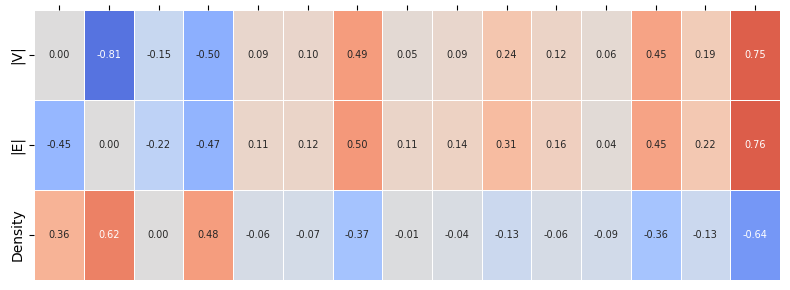

In [ ]:
cols = [corr_metrics[n] for n in order]

rows = ["order", "size", "density"]

correlation_matrix = np.zeros((len(rows), len(cols)))
for i,m1 in enumerate(rows):
    for j,m2 in enumerate(cols):
        if i == j: continue
        correlation_matrix[i,j] = correlations[metricmap[m1]][metricmap[m2]]
        # correlation_matrix[j,i] = correlations[metricmap[m1]][metricmap[m2]]

# np.fill_diagonal(correlation_matrix,1.0)
# mask = np.triu(np.ones_like(correlation_matrix, dtype=bool),k=1)

# Plot heatmap
plt.figure(figsize=(8, 3))
sns.heatmap(correlation_matrix, 
            annot=True, 
            cmap='coolwarm', 
            xticklabels=["" for n in cols], 
            yticklabels=[namemaps[n] for n in rows], 
            fmt=".2f", 
            linewidths=0.5,
            vmin=-1,vmax=1,
            annot_kws={"size": 7},
            cbar=False
    )


# plt.yticks(rotation=45,ha='right')
plt.gca().xaxis.set_ticks_position('top')
plt.xticks(rotation=25,ha='left')

# plt.title('Correlation Heatmap of Objects')
plt.tight_layout()
plt.savefig("figures/correlation_with_props.pdf")


In [ ]:
print(arr[25])

[5.00000000e+00 0.00000000e+00 1.05839595e+00 3.69786055e+01
 9.57246377e+00 5.55072464e+00 0.00000000e+00 1.98036335e+01
 6.02675355e-01 1.59782609e+01 4.70950007e-02 0.00000000e+00
 1.10511045e+01 2.23107264e-01 1.00000000e+00 9.15887850e-01
 0.00000000e+00 1.07000000e+02 1.38000000e+02 2.43343326e-02
 4.79368718e+00 1.57429691e-01 1.20000000e+01 1.00000000e+00
 2.60267654e-02]


In [ ]:
# import matplotlib.pyplot as plt
# import seaborn as sns
# import pandas as pd
# import numpy as np

# def plot_violin_charts(data):
#     # Create a DataFrame from the array for easier handling
#     df = pd.DataFrame(data)
    
#     # Assuming the second column (index 1) is the label, and columns 2-11 are the features
#     labels = df.iloc[:, 1]  # Labels from the second column
#     features = df.columns[2:]  # Feature columns (from index 2 to the last column)
    
#     num_features = len(features)
#     num_rows = (num_features // 5) + (1 if num_features % 5 != 0 else 0)
#     fig, axes = plt.subplots(num_rows, 5, figsize=(15, num_rows * 4))
    
#     axes = axes.flatten()

#     for idx, feature in enumerate(features):
#         # Create a subplot for each feature
#         ax = axes[idx]
        
#         # Create a violin plot for the current feature, grouped by the second column label
#         sns.violinplot(x=labels, y=df[feature],ax=ax,hue=labels,legend=False,palette=["#9467bd", "#8c564b", "#2ca02c", "#1f77b4", "#ff7f0e", ]
#                        ,cut=0)
        
#         # Set title and axis labels
#         ax.set_title(f"{metrics[idx]}")
#         # plt.xlabel(f'Label (Second Column)')
#         ax.set_xticks(ticks=range(5), labels=[algmap[i] for i in range(5)])
#         ax.set_ylabel("")
#         ax.set_xlabel("")
    
#     # Adjust the layout to fit all plots
#     plt.tight_layout()
#     plt.savefig("figures/violins.pdf")

# # Example usage:
# # Assuming `data` is your n x 12 array
# # data = np.array([...])  # Replace this with your actual data

# plot_violin_charts(arr[:,:16])

In [ ]:
def linearize_dataframe(df):
    # Create a long-format dataframe where each value becomes a row
    long_df = df.reset_index().melt(id_vars='index', var_name='graph', value_name='value')
    
    # Rename the columns to match the desired format
    long_df = long_df.rename(columns={'index': 'algorithm'})
    
    return long_df

<Axes: xlabel='value', ylabel='Count'>

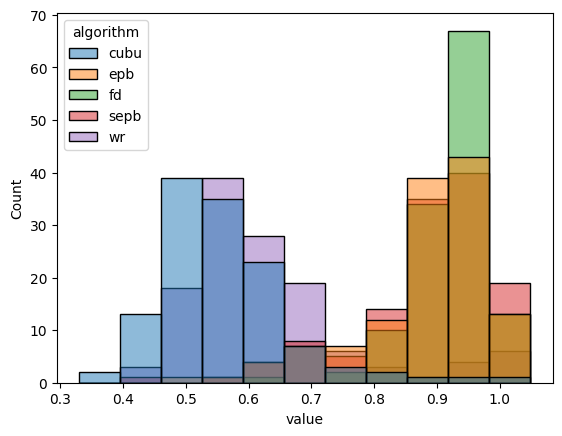

In [ ]:
import seaborn as sns
distortion = linearize_dataframe(mdf['inkratio'])

sns.histplot(distortion, x='value', hue='algorithm',)

<Axes: xlabel='value', ylabel='Density'>

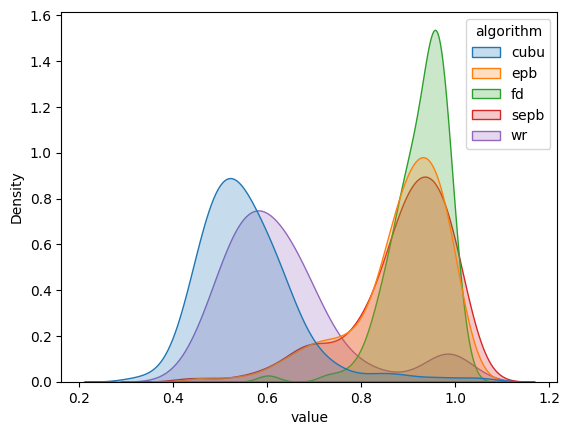

In [ ]:
sns.kdeplot(distortion,x='value',hue='algorithm',fill=True)


In [ ]:
if not os.path.isdir("figures/kde"): os.mkdir("figures/kde")
if not os.path.isdir("figures/violin"): os.mkdir("figures/violin")


algs = ["CuBu", "EPB", "FD", "S-EPB", "WR"]
for metric in metrics:
    metricdf = linearize_dataframe(mdf[metric])

    fig,ax = plt.subplots()
    sns.kdeplot(metricdf,x='value',hue='algorithm',palette=colors,ax=ax,legend=False,fill=True)
    ax.set_xlabel(f"{metric}")
    ax.set_title(f"{metric}")

    largex = np.percentile(metricdf['value'],1)
    ax.set_xlim(0,max(max(metricdf['value']), 1))

    fig.set_size_inches(5,2)
    fig.tight_layout()
    fig.savefig(f"figures/kde/{metric}.pdf")
    plt.close(fig)

    fig,ax = plt.subplots()
    sns.violinplot(metricdf, x='value', y='algorithm',hue='algorithm', palette=colors,ax=ax,legend=False,)


    fig.savefig(f"figures/violin/{metric}.pdf")
    plt.close(fig)

/tmp/ipykernel_83276/526368533.py:10: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(metricdf,x='value',hue='algorithm',palette=colors,ax=ax,legend=False,fill=True)
